In [3]:
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
env = gym.make('CartPole-v0')


/home/prayash/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [4]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output,n_hidden):
        super(ActorCriticModel,self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.action = nn.Linear(n_hidden,n_output)
        self.value = nn.Linear(n_hidden,1)

    def forward(self, x):
        #print(x)
        x= torch.Tensor(x)
        x = F.relu(self.fc(x))
       # print(x)
        action_probs = F.softmax(self.action(x),dim =-1 )
        state_values = self.value(x)
        return action_probs , state_values 


In [5]:
class PolicyNetwork():
    def __init__(self, n_state, n_action,n_hidden =50, lr = 0.001):
        self.model = ActorCriticModel(
            n_state, n_action, n_hidden
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size = 10 ,
            gamma = 0.9 
        )

    def predict(self, s):
        
        return self.model(torch.Tensor(s))
    
    def update(self,returns,  log_probs, state_values):
        loss = 0 
        for log_prob, value, Gt in zip (log_probs,state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value,Gt)
            loss += policy_loss  + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        action_probs, state_value = self.predict(s)
        action = torch.multinomial(action_probs,1 ).item()
        log_prob = torch.log(action_probs[action])
        return action, log_prob, state_value
    
    


In [6]:
def actor_critic(env, estimator , n_episode, gamma = 1.0 ):
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values = []
        state,_ = env.reset()
        is_done = False
        while True:
            action, log_prob , state_value = estimator.get_action(state)
            #print(action)
            next_state , reward, terminated, truncated ,_= env.step(action)
            if terminated or truncated:
                is_done = True
          #  print('reward : ',reward)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)

            if is_done:
                returns = []
                Gt = 0
                pw = 0 
                for reward in rewards[::-1]:
                    Gt += gamma ** pw *reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean())/(returns.std() + 1e-9)
                estimator.update(
                    returns, log_probs, state_values
                
                )
                print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))

                if total_reward_episode[episode] >= 195 :
                    estimator.scheduler.step()
                break
            state = next_state

In [7]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action , n_hidden, lr)
gamma = 0.9

In [8]:
n_episode = 1000
total_reward_episode = [0] * n_episode
actor_critic(env, policy_net, n_episode, gamma)


0
0
1
0
0
1
1
0
1
0
1
0
1
0
1
1
1
1
0
1
Episode: 0, total reward: 20.0
0
0
0
0
0
0
0
0
0
0
Episode: 1, total reward: 10.0
0
0
0
0
1
0
0
0
1
Episode: 2, total reward: 9.0
0
0
0
0
0
0
0
0
Episode: 3, total reward: 8.0
0
0
0
0
0
0
0
1
0
0
Episode: 4, total reward: 10.0
0
0
0
0
0
0
0
0
1
Episode: 5, total reward: 9.0
0
0
0
0
0
0
0
0
0
Episode: 6, total reward: 9.0
0
0
0
0
0
0
0
0
Episode: 7, total reward: 8.0
0
0
0
0
0
0
0
0
Episode: 8, total reward: 8.0
0
0
0
0
0
0
0
0
1
0
Episode: 9, total reward: 10.0
0
0
0
0
0
0
0
1
0
Episode: 10, total reward: 9.0
0
0
0
0
0
0
1
0
1
1
Episode: 11, total reward: 10.0
0
0
0
0
0
0
0
0
0
1
Episode: 12, total reward: 10.0
0
0
0
0
0
0
0
1
1
Episode: 13, total reward: 9.0
0
0
0
0
0
0
0
0
0
1
Episode: 14, total reward: 10.0
0
0
0
0
0
0
0
0
0
1
Episode: 15, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 16, total reward: 10.0
0
0
0
0
0
0
0
1
0
0
1
Episode: 17, total reward: 11.0
0
0
0
0
0
0
0
1
0
0
Episode: 18, total reward: 10.0
0
0
0
0
0
0
0
0
0
Episode: 19,

/tmp/ipykernel_342/1155069157.py:22: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value,Gt)


Episode: 41, total reward: 8.0
0
0
0
0
0
0
0
0
0
Episode: 42, total reward: 9.0
0
0
0
0
0
0
0
0
0
0
Episode: 43, total reward: 10.0
0
0
0
0
0
0
0
0
Episode: 44, total reward: 8.0
0
0
0
0
0
0
0
0
Episode: 45, total reward: 8.0
0
0
0
0
0
0
0
0
0
0
Episode: 46, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 47, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 48, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 49, total reward: 10.0
0
0
0
0
0
0
0
0
0
Episode: 50, total reward: 9.0
0
0
0
0
0
0
0
0
0
Episode: 51, total reward: 9.0
0
0
0
0
0
0
0
0
0
0
Episode: 52, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 53, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 54, total reward: 10.0
0
0
0
0
0
0
0
0
0
Episode: 55, total reward: 9.0
0
0
0
0
0
0
0
0
0
0
Episode: 56, total reward: 10.0
0
0
0
0
0
0
0
0
0
0
Episode: 57, total reward: 10.0
0
0
0
0
0
0
0
0
0
Episode: 58, total reward: 9.0
0
0
0
0
0
0
0
0
Episode: 59, total reward: 8.0
0
0
0
0
0
0
0
0
0
0
Episode: 60, total reward: 10.0
0
0
0
0
0
0

KeyboardInterrupt: 

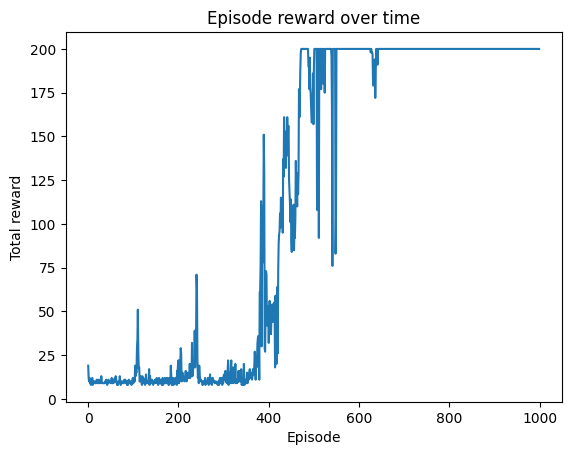

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()